In [9]:
import os, subprocess, datetime, traceback
import numpy as np
import h5py
import pandas as pd
import re
from collections import defaultdict


ID del campione [default: 153]:  
Lunghezza X [default: 60]:  
Lunghezza Y [default: 60]:  
Lunghezza Z [default: 960]:  
Seed random [default: 9117116]:  
Delta T aggiuntivo (newdT) [default: 0]:  
Delta T da aggiungere a Tsource [default: 100]:  
Metodo di analisi (polyfit o average) [default: polyfit]:  
Bin size (Angstrom) [default: 2]:  
Filtro rugosità superficie [default: 10]:  
Nexclude (default 2) [default: 2]:  


1148.0
Compiling MulSKIPS with box size: 60 x 60 x 960
Directory changed to: /Users/filipporuberto/miniforge3/envs/mulskips_env/MulSKIPS/mulskips-source

********************************** Starting MulSKIPS compilation **********************************
MulSKIPS:	rm ./modules/defdertype.o ./modules/defsystem.o ./modules/definitions.o ./initial/SetAPB.o ./initial/SetInvPC.o ./initial/SetInvPwAPB.o ./initial/SetNCSp.o ./initial/SetNCSpSi.o ./initial/SetAPBSym.o ./initial/SetInvP.o ./initial/SetInvPwOnlyCorSi.o ./initial/SetSiC3C.o ./initial/SetSiCSF.o ./initial/SetSiGex.o ./initial/SetSiC3Cww.o ./initial/SetSiC3Cwwaperture.o ./initial/SetSi.o ./initial/SetSiFINFET.o ./initial/SetCAD.o ./initial/SetT.o ./initial/SetShape.o ./initial/SetAPBSymZimb1.o ./initial/SetInvPOff.o ./initial/SetInvPwOnlySiorC.o ./initial/SetTrenchSi.o ./initial/SetTrench.o ./initial/SetAPBSymZimb.o ./initial/SetInvPSi.o ./initial/SetNC.o ./inpout/FileClose.o ./inpout/GetOutputFileName.o ./inpout/WriteMolMolXYZFile.

ld: warning: ignoring duplicate libraries: '-lgfortran', '-lquadmath'


********************************** Finished MulSKIPS compilation **********************************

Directory changed to: /Users/filipporuberto/miniforge3/envs/mulskips_env
*** Initializing PVD process for SiC-3C substrate with precursors ['Si', 'Si2C', 'SiC2']
precursor_masses 	--> Precursor Masses [kg/mol]: {'Si': 0.028085000000000002, 'Si2C': 0.068181, 'SiC2': 0.052107}
mass 			--> Substrate Mass [Kg/mol]: 0.040096
rho 			--> Substrate Density [Kg/m^3]: 3210
rho_surf 		--> Substrate Surface density [Kg/m^2]: 1.400038787156981e-06
calibration_type 	--> Calibration of fluxes taken from:  avrov
Tsource 	--> Temperature at source:  2453.35
Tseed_center 	--> Temperature at seed center: 2345.39
KMC_sf 			--> Substrate KMC super-lattice constant [angstrom]: 0.36333333333333334
listcry 		--> Crystalline species in the substrate: ['Si', 'C']
listcryZ 		--> Atomic number of Crystalline species in the substrate: [14, 6]
calibration_params 	--> Calibration parameters:
     fact_D_Si 	--> [1.10

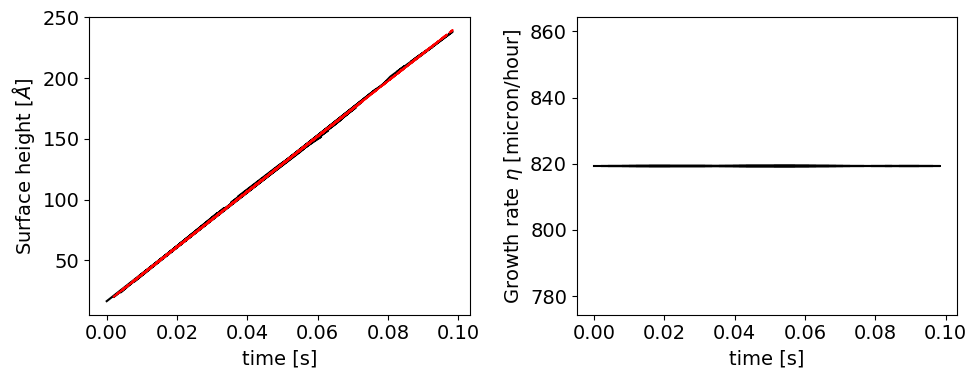

There are 51 'undercoordinated' files available in parser/data-100-0-9117116
✔️ Creato parser/data-100-0-9117116/surf_height.txt
{'tot': array([1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,
       1, 1, 0, 1, 1, 1, 2, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 2, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 1]), 'SV': array([1, 1, 0, 1, 1, 0, 2, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2,
       1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 1, 0, 1, 0]), 'CV': array([0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 1]), 'SAV': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0]), 'CAV': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [13]:
from pymulskips.setuprun import setup_mulskips_src, run_mulskips
from pymulskips import setuprun, process
from analyze_PVD_SiC import (
    analyze_growth_rate,
    count_vacancies,
    read_output_files
)
# === Helper ===
def set_ds(group, name, value, unit=None):
    ds = group.create_dataset(name, data=value)
    if unit:
        ds.attrs['units'] = unit
    return ds

def ask_value(prompt, default, cast):
    val = input(f"{prompt} [default: {default}]: ")
    return cast(val) if val.strip() else default

def merge_xyz_files(dirname, outfile):
    files = sorted(f for f in os.listdir(dirname) if f.startswith("I") and f.endswith(".xyz"))
    with open(outfile, "w") as out:
        for f in files:
            path = os.path.join(dirname, f)
            with open(path, "r") as fin:
                out.write(fin.read() + "\n")

# === Input ===
sample_id = ask_value("ID del campione", '153', str)
lenx = ask_value("Lunghezza X", 60, int)
leny = ask_value("Lunghezza Y", 60, int)
lenz = ask_value("Lunghezza Z", 960, int)
randseed = ask_value("Seed random", 9117116, int)
newdT = ask_value("Delta T aggiuntivo (newdT)", 0, float)
dT = ask_value("Delta T da aggiungere a Tsource", 100, float)
method = ask_value("Metodo di analisi (polyfit o average)", 'polyfit', str)
bin_size = ask_value("Bin size (Angstrom)", 2, float)
surface_roughness = ask_value("Filtro rugosità superficie", 10, float)
Nexclude = ask_value("Nexclude (default 2)", 2, int)

# === Costanti ===
execpath = '/Users/filipporuberto/miniforge3/envs/mulskips_env/MulSKIPS/mulskips-source'
DATA_SAMPLES = {
    '153': {
        'Power': 6.10,
        'T_seed_middle': 2072.24,
        'T_seed_edge': 0,
        'T_source_middle': 2080.20,
        'T_source_edge': 2080.20,
        'Exp-Growth-Rate': 287
    }
}
data = dict(DATA_SAMPLES[sample_id])
tseed = data['T_seed_middle'] + 273.15 + newdT
tsource_0 = data['T_source_middle'] + 273.15 + newdT
tsource = tsource_0 + dT
gr = data['Exp-Growth-Rate'] * (dT / 25 if dT != 0 else 1)
print(gr)

KMC_lattice_constant = 0.436 / 12
alat = 4.36

# Tempo totale
target_thickness = 0.90 * lenz * KMC_lattice_constant * 1e-3
tottime = 3600 * target_thickness / gr
Nout = 50
runpath = f"parser/data-{dT}-{newdT}-{randseed}"
os.makedirs(runpath, exist_ok=True)

# === Run MulSKIPS ===
setup_mulskips_src(execpath, lenx, leny, lenz)
pvdclass = process.PVD(substrate='SiC-3C', precursors=['Si', 'Si2C', 'SiC2'],
                       calibration_type='avrov', Tsource=tsource, Tseed_center=tseed)
setuprun.RunType = 'R'
setuprun.IDUM = randseed
setuprun.setup_only = False
setuprun.TotTime = tottime
setuprun.OutTime = tottime / Nout
setuprun.OutMolMol = 1
setuprun.Seed_box = [48, 0, 0]
run_mulskips(execpath, runpath, 'F', pvdclass,
             PtransZig=0.93, ExitStrategy='Time', SaveCoo=False)

# === Analisi ===
surf_file = os.path.join(runpath, "surf_height.txt")
xyz_file = os.path.join(runpath, f"{randseed}_v.xyz")
results_file = os.path.join(runpath, "results.txt")
logfile = os.path.join(runpath, "runlog.txt")

try:
    growth_rate, surf_heights = analyze_growth_rate(
        runpath, method=method, return_surf_height=True,
        surface_roughness=surface_roughness, bin_size=bin_size,
        Nexclude=Nexclude)

    if (not np.isfinite(growth_rate)) or (hasattr(surf_heights, '__len__') and len(surf_heights) < 3):
        raise ValueError("Growth rate is NaN, infinite o con troppi pochi frame")
    else:
     avg_surf_height = float(np.mean(surf_heights))


    # Salvataggio surf_height.txt
    files = read_output_files(runpath, 'undercoordinated')
    if len(files) == len(surf_heights):
        time_list = []
        for file in files:
            with open(file) as f:
                time_list.append(float(f.readline().split()[3]))
        nu = 1.0
        time_list = [t * nu for t in time_list]
        with open(surf_file, "w") as f:
            for t, h in zip(time_list, surf_heights):
                f.write(f"{t:.6e} {h*1e-4:.6e}\n")
        print(f"✔️ Creato {surf_file}")
    else:
        print("⚠️ Numero di file .xyz e surface height non coincide")

except Exception as e:
    print(f"⚠️ Growth rate fallita: {e}")
    growth_rate, avg_surf_height = np.nan, np.nan

# === Altri file ===
def read_file(path):
    with open(path) as f:
        return f.read()

def count_vacancies(dirname):
    import glob
    keys = ['tot', 'SV', 'CV', 'SAV', 'CAV', 'XV']
    vac_counts = {k: [] for k in keys}
    for file_name in glob.glob(dirname+"/*_v.xyz"):
        if file_name != dirname+"/I00000000_v.xyz":
            vac_counts['tot'].append(int(subprocess.check_output(f'tail -n +3 "{file_name}" | wc -l', shell=True)))
            for key in keys[1:]:
                vac_counts[key].append(int(subprocess.check_output(f'grep "{key}" "{file_name}" | wc -l', shell=True)))
    return {k: np.array(v) for k,v in vac_counts.items()}

vac_data = count_vacancies(runpath)
print(vac_data)

try:
    subprocess.run(f"cat {runpath}/start.dat > {logfile}", shell=True, check=True)
except Exception as e:
    print(f"⚠️ Log fallito: {e}")

if not os.path.exists(xyz_file):
    try:
        merge_xyz_files(runpath, xyz_file)
        print(f"✔️ Creato {xyz_file}")
    except Exception as e:
        print(f"⚠️ Merge .xyz fallito: {e}")

if not os.path.exists(results_file) and not np.isnan(growth_rate):
    try:
        with open(results_file, "w") as f:
            f.write(f"growth_rate [micron/hour] = {growth_rate:.6f}\n")
        print(f"✔️ Creato {results_file}")
    except Exception as e:
        print(f"⚠️ Scrittura results fallita: {e}")

if not os.path.exists(logfile) and not np.isnan(avg_surf_height):
    try:
        with open(logfile, "w") as f:
            f.write(f"Log creato automatico\navg_surf_height = {avg_surf_height:.3f} Å\n")
        print(f"✔️ Creato {logfile}")
    except Exception as e:
        print(f"⚠️ Scrittura log fallita: {e}")

In [12]:
# === SCRITTURA NEXUS ===
nexus_file = f"SiC_sample_{sample_id}.nxs"
try:
    with h5py.File(nexus_file, 'w') as f:
        f.attrs['NX_class'] = 'NXroot'
        f.create_dataset('default', data=b'NXmicrostructure_imm_results')

        def grp(name):
            g = f.create_group(name)
            g.attrs['NX_class'] = name
            return g

        software = grp('NXsoftware')
        set_ds(software, 'name', b'MulSKIPS')
        set_ds(software, 'version', b'1.0')
        set_ds(software, 'description', b'Multiscale KMC for PVD SiC')

        user = grp('NXuser')
        set_ds(user, 'name', b'Filippo Ruberto')
        set_ds(user, 'affiliation', b'CNR-IMM@CT')
        set_ds(user, 'email', b'filippo.ruberto@cnr.it')
        set_ds(user, 'ORCID', b'0000-0002-1234-5678')

        project = grp('NXproject')
        set_ds(project, 'name', b'MulSKIPS@CNR-IMM')
        set_ds(project, 'description', b'Multiscale modeling of PVD growth of SiC')
        set_ds(project, 'grant_number', b'FAIRmat-NFDI')

        prov = grp('NXprovenance')
        set_ds(prov, 'source', b'https://github.com/mulskips/mulskips-source')
        set_ds(prov, 'modification_date', str(datetime.datetime.now()))

        conf = grp('NXmicrostructure_imm_config')
        set_ds(conf, 'power', data['Power'], 'W')
        set_ds(conf, 'temperature_seed', tseed, 'K')
        set_ds(conf, 'temperature_source', tsource, 'K')
        set_ds(conf, 'initial_temperature_source', tsource_0, 'K')
        set_ds(conf, 'temperature_difference', dT, 'K')
        set_ds(conf, 'additional_temperature_shift', newdT, 'K')
        set_ds(conf, 'geometry/lenx', lenx, 'lattice units')
        set_ds(conf, 'geometry/leny', leny, 'lattice units')
        set_ds(conf, 'geometry/lenz', lenz, 'lattice units')
        set_ds(conf, 'KMC_lattice_constant', KMC_lattice_constant, 'nm')
        set_ds(conf, 'alat_angstrom', alat, 'Angstrom')
        set_ds(conf, 'simulation_type', b'PVD')
        set_ds(conf, 'substrate_material', b'SiC-3C')
        conf.create_dataset('precursors', data=np.array([b'Si', b'Si2C', b'SiC2']))
        set_ds(conf, 'experiment_identifier', f'PVD-SiC-Run-{sample_id}'.encode())
        set_ds(conf, 'deposition_time', tottime, 's')
        set_ds(conf, 'output_steps', Nout)
        set_ds(conf, 'target_thickness', target_thickness, 'mm')
        set_ds(conf, 'random_seed', randseed)
        set_ds(conf, 'timestamp', str(datetime.datetime.now()))
        set_ds(conf, 'run_directory', runpath.encode())

        set_ds(conf, 'simulation_parameters/PtransZig', 0.93)
        set_ds(conf, 'simulation_parameters/ExitStrategy', b'Time')
        set_ds(conf, 'simulation_parameters/SaveCoo', b'False')
        conf.create_dataset('simulation_parameters/Seed_box', data=[48, 0, 0])
        set_ds(conf, 'simulation_parameters/setup_only', b'False')
        set_ds(conf, 'analysis/bin_size', bin_size, 'cm')
        set_ds(conf, 'analysis/surface_roughness', surface_roughness)
        set_ds(conf, 'analysis/Nexclude', Nexclude)

        res = grp('NXmicrostructure_imm_results')
        set_ds(res, 'growth_rate', 0.0 if np.isnan(growth_rate) else growth_rate, 'micron/hour')
        avg_val = float(np.mean(surf_heights)) if hasattr(surf_heights, '__len__') else 0.0
        set_ds(res, 'avg_surface_height', avg_val, 'micron')
        set_ds(res, 'growth_rate_method', np.string_(method))
        set_ds(res, 'experimental_growth_rate', data['Exp-Growth-Rate'], 'micron/hour')
        set_ds(res, 'alat_used', alat, 'Angstrom')
        set_ds(res, 'analysis_time', str(datetime.datetime.now()))
        set_ds(res, 'total_time', tottime, 's')
        set_ds(res, 'num_outputs', Nout)
        set_ds(res, 'target_thickness', target_thickness, 'mm')
        set_ds(res, 'vacancies_total', vac_data.get('tot', -1))

        for k, v in vac_data.items():
            set_ds(res, f'vacancy_{k}', v)

        if os.path.exists(xyz_file):
            set_ds(res, 'xyz_file', np.string_(xyz_file))

        try:
            if os.path.exists(results_file):
                results_txt = read_file(results_file)
                set_ds(res, 'results_txt', np.string_(results_txt))

                lines = results_txt.strip().splitlines()
                hdrs_line = next((l.lstrip("# ") for l in lines if l.strip().startswith("#") and any(k in l for k in ["Tsource", "GR", "conc"])), None)
                hdrs = hdrs_line.split() if hdrs_line else []
                data_rows = []
                for l in lines:
                    if l.strip().startswith('#') or not l.strip():
                        continue
                    try:
                        nums = list(map(float, l.split()))
                        if len(nums) == len(hdrs):
                            data_rows.append(nums)
                    except:
                        continue
                if data_rows and hdrs:
                    data_mat = np.array(data_rows)
                    for i, h in enumerate(hdrs):
                        set_ds(res, f'results_table/{h}', data_mat[:, i])
                else:
                    print("⚠️ Tabella results.txt vuota o senza dati numerici validi.")
        except Exception as e:
            print(f"⚠️ Tabella results.txt fallita: {e}")

        try:
            if os.path.exists(surf_file):
                txt = read_file(surf_file)
                try:
                    tab = np.loadtxt(surf_file)
                    if tab.ndim == 1:
                        tab = tab.reshape(-1, 2)
                    set_ds(res, 'surf_height_txt', np.string_(txt))
                    set_ds(res, 'surf_height/time', tab[:, 0], 's')
                    set_ds(res, 'surf_height/height', tab[:, 1], 'micron')
                except Exception as parse_err:
                    print(f"⚠️ Errore parsing surf_height.txt: {parse_err}")
                    set_ds(res, 'surf_height_txt', np.string_(txt))
        except Exception as e:
            print(f"⚠️ surf_height.txt fallita: {e}")
            set_ds(res, 'surf_height_txt', np.string_("null"))

        log = grp('simulation_log')
        log_txt = read_file(logfile) if os.path.exists(logfile) else ""
        set_ds(log, 'description', b'MulSKIPS simulation log')
        set_ds(log, 'data', np.string_(log_txt))

    print(f"✅ File NeXus scritto con successo: {nexus_file}")
except Exception as e:
    print(f"❌ Errore nella scrittura del NeXus: {e}")
    traceback.print_exc()

⚠️ Tabella results.txt vuota o senza dati numerici validi.
✅ File NeXus scritto con successo: SiC_sample_153.nxs
